# Setup

In [5]:
import os
from IPython.display import clear_output

import cv2
%matplotlib inline 
from matplotlib import pyplot as plt

import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

from pylibdmtx.pylibdmtx import decode
from ultralytics import YOLO, settings
root_dir = os.getcwd().replace('\\notebooks', '')
settings.update({'datasets_dir': f'{root_dir}/data/processed/test', 'runs_dir': f'{root_dir}/yolo/runs'})

import torch
import torch.nn as nn
from torchvision.transforms import v2, InterpolationMode
from torchvision.models.resnet import ResNet18_Weights
from torchvision import models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Live Binarizer pipeline

In [6]:
# Class definition copied from image_binarizer.ipynb
class binarizer(nn.Module):
    def __init__(self):
        super(binarizer, self).__init__()

        # Load the pretrained ResNet-18 model
        resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

        # Use the ResNet layers up to the last layer (remove the fully connected layer)
        self.encoder = nn.Sequential(*list(resnet18.children())[:-2]) # output size = 512 x 8 x 8

        # Define the decoder part to upsample back to 512 x 512
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() # Use sigmoid for binary output in range [0, 1]
        )

    def forward(self, x):
        '''Pass input through the resnet-18 encoder and custom decoder'''
        # print('FORWARD A')
        x = self.encoder(x)
        # print('FORWARD B')
        x = self.decoder(x)
        return x

# Load the trained model
model_binarizer = binarizer().to(device)
model_binarizer.load_state_dict(torch.load('../torch/binarizer_0.pt', map_location=device))
model_binarizer.eval()

binarizer(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [7]:
# Function to prepare image for model input
def prepare_image(img):
    transform = v2.Compose([
        v2.Resize((512, 512), interpolation=InterpolationMode.BILINEAR), # Resize to match model input
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # ResNet normalization
        # v2.Normalize(mean=mean, std=std) # custom normalization
    ])

    img = transform(img).unsqueeze(0).to(device)
    return img

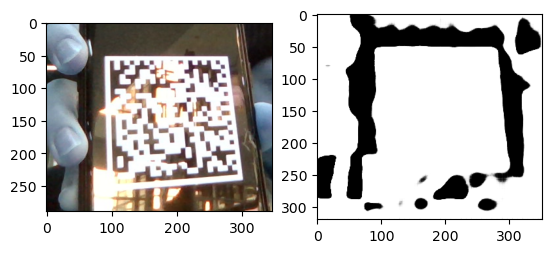


0: 480x640 (no detections), 123.1ms
Speed: 6.1ms preprocess, 123.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 114.7ms
Speed: 0.0ms preprocess, 114.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 110.5ms
Speed: 2.6ms preprocess, 110.5ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 111.3ms
Speed: 0.0ms preprocess, 111.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 106.7ms
Speed: 0.0ms preprocess, 106.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 118.0ms
Speed: 17.6ms preprocess, 118.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 98.5ms
Speed: 3.8ms preprocess, 98.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 133.0ms
Speed: 0.0ms prepro

In [10]:
# Getting cropped images
model = YOLO('../yolo/models/ultralytics_finetuned.pt')

# stat tracking
num_decodings = 0
num_valid_decodings = 0

imgs = []
titles = []

# Open camera
cam = cv2.VideoCapture(0)

# set camera focus
# focus = 255
# cam.set(cv2.CAP_PROP_FOCUS, focus)

# Loop through frames
while True:
    ret, frame = cam.read()

    # error handling
    if not ret:
        print("Failed to grab frame")
        break

    # Detect objects
    results = model(frame)
    boxes = results[0].boxes.xyxy.tolist()

    if boxes != None and len(boxes) > 0:
        # only look at box with highest confidence
        box = boxes[0]

        # crop with some padding (to not have too small of a crop)
        pad = 45
        crop_obj_pre_binarize = frame[max(0, int(box[1])-pad):max(0, int(box[3])+pad), max(0, int(box[0])-pad):max(0, int(box[2])+pad)]

        # binarize with resnet model
        crop_obj_prep = prepare_image(crop_obj_pre_binarize)
        output = model_binarizer(crop_obj_prep).cpu().detach().numpy().squeeze()

        # show pre and post binarization crops
        clear_output(wait=True)
        plt.subplot(1, 2, 1)
        plt.imshow(crop_obj_pre_binarize)
        plt.subplot(1, 2, 2)
        plt.imshow(output, cmap='gray')
        plt.show()

        decodings = decode(output,
                           max_count=1,
                           threshold=50,
                           min_edge= 20,
                           max_edge=800,
                           # shape=DmtxSymbolSize.DmtxSymbol16x16,
                           timeout=1000,
                           )

        if decodings != None and len(decodings) > 0:
            num_decodings += 1

            for decoding in decodings:
                decoded_string = decoding.data.decode('utf-8')
                print(decoded_string)
                stop

    cv2.imshow('Camera', frame)

    # Press 'q' to exit the loop
    if cv2.waitKey(1) == ord('q'):
        break

# Release the capture and writer objects
cam.release()
cv2.destroyAllWindows()